In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from typing import Tuple
%matplotlib inline

# CPHASE interaction simulation

In [82]:
# qubit parameters

fH_01_max = 6 # GHz
fL_01_max = 5  # GHz

alphaH = -0.3  # GHz
alphaL = -0.32  # GHz

J = 0.02 # GHz

L = np.array([[1, 0.1], [0.1, 1]])  # current to normalized flux conversion with crosstalk - L11 is LHH

assert fH_01_max + alphaH > fL_01_max, 'unphysical model, please correct'

In [83]:
def fH01(flux: float) -> float:
    """
    return the f01 frequency from the *normalized* flux
    """
    return fH_01_max * np.sqrt(np.abs(np.cos(np.pi * flux)))


def fL01(flux: float) -> float:
    """
    return the f01 frequency from the *normalized* flux
    """
    return fL_01_max * np.sqrt(np.abs(np.cos(np.pi * flux)))


Nh = 3  # Single qubit Hilbert space dimension

# operator definitions

a = qp.destroy(Nh)
I = qp.qeye(Nh)

aH = qp.tensor([a, I])
aL = qp.tensor([I, a])

nH = aH.dag() * aH
nL = aL.dag() * aL

# dynamic coupling interaction operators
J_minus = aH.dag() * aL
J_plus = aL.dag() * aH

# dynamic detuning operator
J_z = (nL - nH)/2


def H0(i_vec: np.ndarray) -> qp.Qobj:
    flux_vec = L @ i_vec

    H_H = 2*np.pi*fH01(flux_vec[0])*nH + 2*np.pi*(alphaH/2)*aH.dag()**2*aH**2
    H_L = 2*np.pi*fL01(flux_vec[1])*nL + 2*np.pi*(alphaL/2)*aL.dag()**2*aL**2
    return H_H + H_L


def H_int():
    return np.pi*J*(J_plus + J_minus)


In [84]:
def eigen_spectroscopy(H: qp.Qobj) -> np.ndarray:
    """
    Find eigenenergies of H, but plot them spectroscopically, i.e. show how they would react to multiphoton transitions
    """
    eig = H.eigenenergies()
    eig[3] /= 2  # 02/2
    eig[4] /= 2  # 11/2
    eig[5] /= 2  # 20/2
    eig[6] /= 3  # 12/3
    eig[7] /= 3  # 21/3
    eig[8] /= 3  # 22/4
    return eig

## Find the avoided level crossing

In [85]:
from scipy.optimize import fsolve

def energy_diff(iH: float) -> float:
    iH = iH[0]
    e11_index = 4
    e20_index = 6
    diag = H0(np.array([iH, 0])).diag()
    return diag[e11_index] - diag[e20_index]

ac_20_11 = fsolve(energy_diff, 0.215)

(4.7299999999999995, 5.3999999999999995)

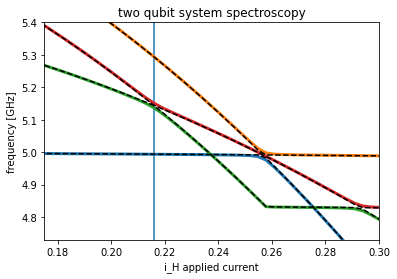

In [86]:
iH_vec = np.linspace(-0.3, 0.3, 200)

plt.plot(iH_vec, np.array([eigen_spectroscopy(H0([i, 0]) + H_int())[[1, 2, 4, 5]] for i in iH_vec])/(2*np.pi), linewidth=3);

plt.plot(iH_vec, np.array([eigen_spectroscopy(H0([i, 0]))[[1, 2, 4, 5]] for i in iH_vec])/(2*np.pi), 'k--');
plt.xlabel('i_H applied current')
plt.ylabel('frequency [GHz]')
plt.title('two qubit system spectroscopy')
plt.vlines(ac_20_11, 0, 10)
plt.xlim((0.175, 0.3))  # todo: make this depedent on frequency values
plt.ylim((fL_01_max + alphaL + 0.05, fL_01_max - alphaH + 0.1))

## Perform the experiment

In [87]:
# time dependent functions
def detune(t, args):
    if args['t_start_swap'] < t and t < args['t_start_swap'] + args['swap_duration']:
        return 2*np.pi*(fH01(args['interaction_current']) - fH_01_max)
    else:
        return 0

    
def J_minus_timedep(t, args):
    # J_minus = aH.dag() * aL
    return np.pi*J*np.exp(1j*2*np.pi*(args['fH_01'] - args['fL_01'])*t)


def J_plus_timedep(t, args):
    # J_minus = aH.dag() * aL
    return np.pi*J*np.exp(1j*2*np.pi*(args['fL_01'] - args['fH_01'])*t)


def cosine_pulse(t, t_start, duration):
    # integral_0^d cos(π (t - d/2)/d) dt = (2 d)/π
    return np.pi * np.cos(np.pi*(t - t_start - duration/2)/duration) / (2 * duration)


def qH_drive(t, args):  # this is the baseband signal
    if args['ts1'] < t < args['ts1'] + args['single_pulse_duration']:
        return args['pi_amp'] * cosine_pulse(t, args['ts1'], args['single_pulse_duration'])
#     if args['ts2'] < t and t < args['ts2'] + args['single_pulse_duration']:
#         return args['pi_amp'] * cosine_pulse(t, args['ts2'], args['single_pulse_duration'])
    else:
        return 0

    
def qL_drive(t, args):  # this is the baseband signal
    if args['ts1'] < t < args['ts1'] + args['single_pulse_duration']:
        return args['pi2_amp'] * cosine_pulse(t, args['ts1'], args['single_pulse_duration'])
    if args['ts2'] < t and t < args['ts2'] + args['single_pulse_duration']:
        return args['pi2_amp'] * cosine_pulse(t, args['ts2'], args['single_pulse_duration'])
    else:
        return 0


# functions for a, adag operator coefficients (currently only -Y/2)
def aH_dr(t, args):
    return 0.5 * -1j * qH_drive(t, args) #* np.exp(1j*2*np.pi*args['fH_01']*t)


def aHd_dr(t, args):
    return 0.5 * 1j  * qH_drive(t, args) #* np.exp(-1j*2*np.pi*args['fH_01']*t)


def aL_dr(t, args):
    return 0.5 * -1j * qL_drive(t, args)# * np.exp(1j*2*np.pi*args['fL_01']*t)


def aLd_dr(t, args):
    return 0.5 * 1j * qL_drive(t, args)# * np.exp(-1j*2*np.pi*args['fL_01']*t)

In [88]:
H = [(2*np.pi*(alphaH/2)*aH.dag()**2*aH**2 + 2*np.pi*(alphaL/2)*aL.dag()**2*aL**2),
     [nH, detune],
     [J_minus, J_minus_timedep],
     [J_plus, J_plus_timedep],
     [aH, aH_dr],
     [aH.dag(), aHd_dr],
     [aL, aL_dr],
     [aL.dag(), aLd_dr],
    ]

In [89]:
def simulate(tvec: np.ndarray, args: dict) ->  qp.solver.Result:
    """
    perform a simulation of the Hamltonian over a given timespan
    """
    psi0 = H0([0,0]).groundstate()[1]
    sol = qp.sesolve(H, psi0, tvec,
                     args=args,
    #                  e_ops = project_ops,
                     options=qp.Options(max_step=1))    
    return sol


def get_prob_phase(sol: qp.solver.Result) -> Tuple[np.ndarray, np.ndarray]:
    """
    get the probability and phase of the Fock states from the solution of the simulation
    """
    arr = np.array([ss.full() for ss in sol.states]).squeeze().T
    return np.abs(arr)**2, np.angle(arr)

## Example of a CZ (on resonance and one rotation)

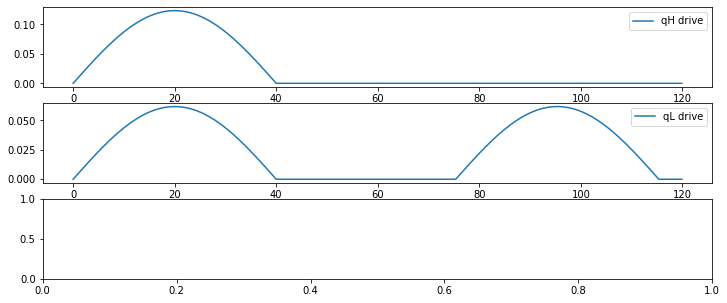

In [130]:
single_pulse_duration = 40

local_args = dict(
    fH_01=fH_01_max,
    fL_01=fL_01_max,
    t_start_swap=40,
    swap_duration=1/J/np.sqrt(2),
    single_pulse_duration=single_pulse_duration,
    ts1=0,
    ts2=single_pulse_duration + swap_duration,
    pi_amp=np.pi,
    pi2_amp=np.pi/2,
    interaction_current=ac_20_11
)
local_tvec = np.arange(0, 120, 0.1)
fig, ax = plt.subplots(3, 1, figsize=(12, 5))

ax[0].plot(local_tvec, [qH_drive(t, local_args) for t in local_tvec], label='qH drive')
ax[0].legend()
ax[1].plot(local_tvec, [qL_drive(t, local_args) for t in local_tvec], label='qL drive')
ax[1].legend()


In [131]:
sol = simulate(local_tvec, local_args)
prob, phase = get_prob_phase(sol)

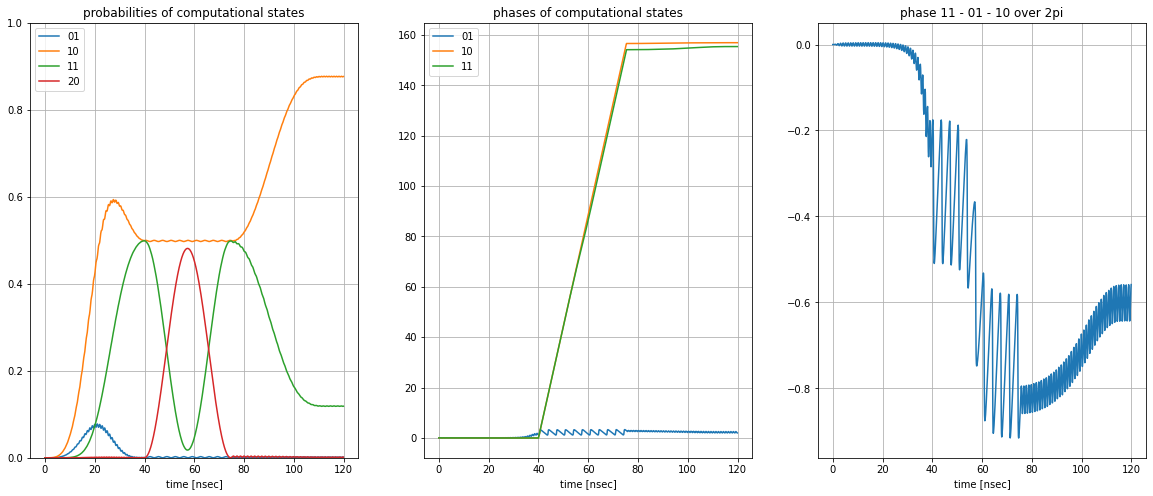

In [132]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].plot(sol.times, prob[1], label='01')
ax[0].plot(sol.times, prob[3], label='10')
ax[0].plot(sol.times, prob[4], label='11')
ax[0].plot(sol.times, prob[6], label='20')
ax[0].legend()
ax[0].set_ylim((0,1))
ax[0].grid('all')
ax[0].set_title('probabilities of computational states')
ax[0].set_xlabel('time [nsec]')

ax[1].plot(sol.times, np.unwrap(phase[1]), label='01')
ax[1].plot(sol.times, np.unwrap(phase[3]), label='10')
ax[1].plot(sol.times, np.unwrap(phase[4]), label='11')
ax[1].legend()
# ax[1].plot(sol.times, phase[6], label='20')
ax[1].grid('all')
ax[1].set_title('phases of computational states')
ax[1].set_xlabel('time [nsec]')

ax[2].plot(sol.times, (np.unwrap(phase[4]) - np.unwrap(phase[3]) - np.unwrap(phase[1]))/(2*np.pi))
ax[2].set_title('phase 11 - 01 - 10 over 2pi')
ax[2].set_xlabel('time [nsec]')
ax[2].grid('all')

## Simulate the sweep

In [14]:
def simulate_circuit(detuning_from_interaction: float, swap_duration: float) -> qp.solver.Result:
    """
    simulate the circuit evolution
    
    detuning_from_interaction: How much does i_H deviate from the interaction point
    swap_duration: Duration to be in interaction point. At zero deviation a CPHASE is 1/J/np.sqrt(2)
    
    returns: the qutip solver object
    """

    circuit_args = dict(
        fH_01=fH_01_max,
        fL_01=fL_01_max,
        t_start_swap=40,
        swap_duration=swap_duration,
        single_pulse_duration=single_pulse_duration,
        ts1=0,
        ts2=single_pulse_duration + swap_duration,
        pi_amp=np.pi,
        pi2_amp=np.pi/2,
        interaction_current=ac_20_11 + detuning_from_interaction
    )    
    tvec = np.arange(0, single_pulse_duration * 2 + swap_duration, 0.1)
    sol = simulate(tvec, circuit_args)
    return sol

In [141]:
from tqdm import tqdm
detune_vec = np.linspace(-0.02, 0.02, 80)
# detune_vec = [0]
time_vec = np.linspace(0, 400, 120)

res = []

for detune in tqdm(detune_vec):
    res.append([])
    for time in time_vec:
        prob, phase = get_prob_phase(simulate_circuit(detune, time))
        n_avg_H = np.dot(prob.T[-1], nH.diag())
        n_avg_L = np.dot(prob.T[-1], nL.diag())
        res[-1].append(np.array([n_avg_H, n_avg_L]))
        
res = np.array(res)

100%|██████████| 80/80 [3:43:35<00:00, 167.70s/it]  


In [142]:
rest = res.transpose([2, 1, 0])

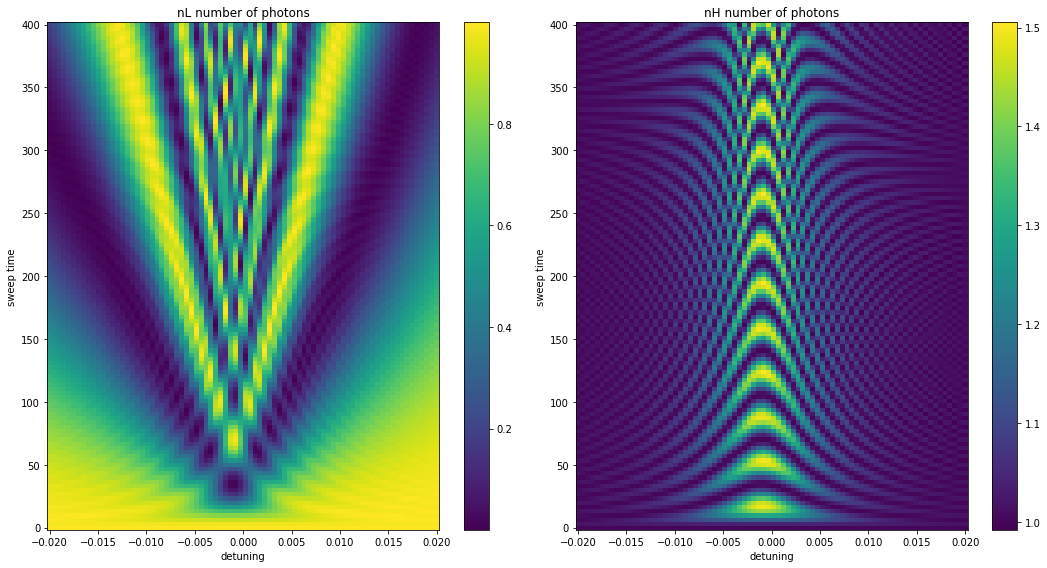

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]
c = ax.pcolor(detune_vec, time_vec, rest[1], shading='auto', )
ax.set_xlabel('detuning')
ax.set_ylabel('sweep time')
ax.set_title('nL number of photons')
fig.colorbar(c, ax=ax)

ax = axes[1]
c = ax.pcolor(detune_vec, time_vec, rest[0], shading='auto')
ax.set_xlabel('detuning')
ax.set_ylabel('sweep time')
ax.set_title('nH number of photons')
fig.colorbar(c, ax=ax)
fig.tight_layout()


In [139]:
qp.qip.operations.y_gate(N=1).sqrtm()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.5+0.5j -0.5-0.5j]
 [ 0.5+0.5j  0.5+0.5j]]